## SVM and SMO

In [98]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

In [99]:
class SMOModel:
    """Container object for the model used for sequential minimal optimization."""
    
    def __init__(self, X, y, C, kernel, alphas, b, errors):
        self.X = X               # training data vector
        self.y = y               # class label vector
        self.C = C               # regularization parameter
        self.kernel = kernel     # kernel function
        self.alphas = alphas     # lagrange multiplier vector
        self.b = b               # scalar bias term
        self.errors = errors     # error cache
        self._obj = []           # record of objective function value
        self.m = len(self.X)     # store size of training set

In [100]:
def linear_kernel(x, y, b=1):
    """Returns the linear combination of arrays `x` and `y` with
    the optional bias term `b` (set to 1 by default)."""
    return x @ y.T + b # Note the @ operator for matrix multiplication


def gaussian_kernel(x, y, sigma=1):
    """Returns the gaussian similarity of arrays `x` and `y` with
    kernel width parameter `sigma` (set to 1 by default)."""
    
    if np.ndim(x) == 1 and np.ndim(y) == 1:                                             # for vector-vector
        result = np.exp(- (np.linalg.norm(x - y, 2)) ** 2 / (2 * sigma ** 2))
    elif (np.ndim(x) > 1 and np.ndim(y) == 1) or (np.ndim(x) == 1 and np.ndim(y) > 1):  # for matrix-vector
        result = np.exp(- (np.linalg.norm(x - y, 2, axis=1) ** 2) / (2 * sigma ** 2))
    elif np.ndim(x) > 1 and np.ndim(y) > 1:                                             # for matrix-matrix
        result = np.exp(- (np.linalg.norm(x[:, np.newaxis] - y[np.newaxis, :], 2, axis=2) ** 2) / (2 * sigma ** 2))
    return result

Let us now define objective function programatically
$$W({\alpha _2}) = \sum\limits_{i = 1}^m {{\alpha _i}}  - \frac{1}{2}\sum\limits_{i,j = 1}^m {{y^{(i)}}{y^{(j)}}{\alpha _i}{\alpha _j}{K_{ij}}} $$

In [101]:
# Objective function to optimize

def objective_function(alphas, target, kernel, X_train):
    """Returns the SVM objective function based in the input model defined by:
    `alphas`: vector of Lagrange multipliers
    `target`: vector of class labels (-1 or 1) for training data
    `kernel`: kernel function
    `X_train`: training data for model."""
    
    return np.sum(alphas) - 0.5 * np.sum((target[:, None] * target[None, :]) * kernel(X_train, X_train) * (alphas[:, None] * alphas[None, :]))

Also define the decision function programatically
$$f(x) = \sum\limits_{i = 1}^n {{\alpha _i}{y^{(i)}}K({x^{(i)}},x)}  - b$$

In [102]:
# Decision function

def decision_function(alphas, target, kernel, X_train, x_test, b):
    """Applies the SVM decision function to the input feature vectors in `x_test`."""
    
    result = (alphas * target) @ kernel(X_train, x_test) - b
    return result

`take_step()` carries out the meat of the calculations and computes the two new α values, a new threshold b, and updates the error cache.

Actually this is coordinate ascend Algorithm

In [103]:
def take_step(i1, i2, model):
    
    # Skip if chosen alphas are the same
    if i1 == i2:
        return 0, model
    
    alph1 = model.alphas[i1]
    alph2 = model.alphas[i2]
    y1 = model.y[i1]
    y2 = model.y[i2]
    E1 = model.errors[i1]
    E2 = model.errors[i2]
    s = y1 * y2
    
    # Compute L & H, the bounds on new possible alpha values
    if (y1 != y2):
        L = max(0, alph2 - alph1)
        H = min(model.C, model.C + alph2 - alph1)
    elif (y1 == y2):
        L = max(0, alph1 + alph2 - model.C)
        H = min(model.C, alph1 + alph2)
    if (L == H):
        return 0, model

    # Compute kernel & 2nd derivative eta
    k11 = model.kernel(model.X[i1], model.X[i1])
    k12 = model.kernel(model.X[i1], model.X[i2])
    k22 = model.kernel(model.X[i2], model.X[i2])
    eta = 2 * k12 - k11 - k22
    
    # Compute new alpha 2 (a2) if eta is negative
    if (eta < 0):
        a2 = alph2 - y2 * (E1 - E2) / eta
        # Clip a2 based on bounds L & H
        if L < a2 < H:
            a2 = a2
        elif (a2 <= L):
            a2 = L
        elif (a2 >= H):
            a2 = H
            
    # If eta is non-negative, move new a2 to bound with greater objective function value
    else:
        alphas_adj = model.alphas.copy()
        alphas_adj[i2] = L
        # objective function output with a2 = L
        Lobj = objective_function(alphas_adj, model.y, model.kernel, model.X) 
        alphas_adj[i2] = H
        # objective function output with a2 = H
        Hobj = objective_function(alphas_adj, model.y, model.kernel, model.X)
        if Lobj > (Hobj + eps):
            a2 = L
        elif Lobj < (Hobj - eps):
            a2 = H
        else:
            a2 = alph2
            
    # Push a2 to 0 or C if very close
    if a2 < 1e-8:
        a2 = 0.0
    elif a2 > (model.C - 1e-8):
        a2 = model.C
    
    # If examples can't be optimized within epsilon (eps), skip this pair
    if (np.abs(a2 - alph2) < eps * (a2 + alph2 + eps)):
        return 0, model
    
    # Calculate new alpha 1 (a1)
    a1 = alph1 + s * (alph2 - a2)
    
    # Update threshold b to reflect newly calculated alphas
    # Calculate both possible thresholds
    b1 = E1 + y1 * (a1 - alph1) * k11 + y2 * (a2 - alph2) * k12 + model.b
    b2 = E2 + y1 * (a1 - alph1) * k12 + y2 * (a2 - alph2) * k22 + model.b
    
    # Set new threshold based on if a1 or a2 is bound by L and/or H
    if 0 < a1 and a1 < C:
        b_new = b1
    elif 0 < a2 and a2 < C:
        b_new = b2
    # Average thresholds if both are bound
    else:
        b_new = (b1 + b2) * 0.5

    # Update model object with new alphas & threshold
    model.alphas[i1] = a1
    model.alphas[i2] = a2
    
    # Update error cache
    # Error cache for optimized alphas is set to 0 if they're unbound
    for index, alph in zip([i1, i2], [a1, a2]):
        if 0.0 < alph < model.C:
            model.errors[index] = 0.0
    
    # Set non-optimized errors based on above equations
    non_opt = [n for n in range(model.m) if (n != i1 and n != i2)]
    model.errors[non_opt] = model.errors[non_opt] + \
                            y1*(a1 - alph1)*model.kernel(model.X[i1], model.X[non_opt]) + \
                            y2*(a2 - alph2)*model.kernel(model.X[i2], model.X[non_opt]) + model.b - b_new
    
    # Update model threshold
    model.b = b_new
    
    return 1, model

Then `examine_example()` implements the second choice heuristic to choose the second α to optimize, and passes the index of both α values to `take_step()`.

In [104]:
#step_result --- both alphas are same or bound same or objective function is not converging then neglect that pair of alphas
def examine_example(i2, model):
    
    y2 = model.y[i2]
    alph2 = model.alphas[i2]
    E2 = model.errors[i2]
    r2 = E2 * y2

    # Proceed if error is within specified tolerance (tol)
    if ((r2 < -tol and alph2 < model.C) or (r2 > tol and alph2 > 0)):
        
        if len(model.alphas[(model.alphas != 0) & (model.alphas != model.C)]) > 1:
            # Use 2nd choice heuristic is choose max difference in error
            if model.errors[i2] > 0:
                i1 = np.argmin(model.errors)
            elif model.errors[i2] <= 0:
                i1 = np.argmax(model.errors)
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
            
        # Loop through non-zero and non-C alphas, starting at a random point
        for i1 in np.roll(np.where((model.alphas != 0) & (model.alphas != model.C))[0],
                          np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
        
        # loop through all alphas, starting at a random point
        for i1 in np.roll(np.arange(model.m), np.random.choice(np.arange(model.m))):
            step_result, model = take_step(i1, i2, model)
            if step_result:
                return 1, model
    
    return 0, model

The `train()` function implements selection of the first α to optimize via the first choice heuristic and passes this value to `examine_example()`.The `train()` function uses a while loop to iterate through the α values in a few different ways until no more optimizations can be made, at which point it returns the optimized α vector (embedded in an SMOModel object).

In [105]:
def train(model):
    
    numChanged = 0
    examineAll = 1

    while(numChanged > 0) or (examineAll):
        numChanged = 0
        if examineAll:
            # loop over all training examples
            for i in range(model.alphas.shape[0]):
                examine_result, model= examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
                            
        else:
            # loop over examples where alphas are not already at their limits
            for i in np.where((model.alphas != 0) & (model.alphas != model.C))[0]:
                examine_result, model = examine_example(i, model)
                numChanged += examine_result
                if examine_result:
                    obj_result = objective_function(model.alphas, model.y, model.kernel, model.X)
                    model._obj.append(obj_result)
        if examineAll == 1:
            examineAll = 0
        elif numChanged == 0:
            examineAll = 1

In [106]:
train_df= pd.read_csv('train.csv')

<IPython.core.display.Javascript object>

In [107]:
train_df.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [108]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='Survived', ylabel='count'>

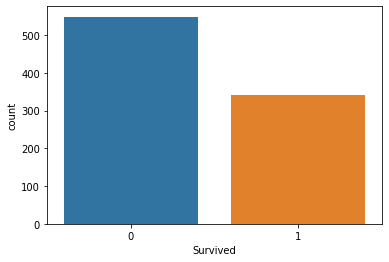

In [109]:
train_df['Survived'].value_counts()
sns.countplot(data=train_df, x='Survived')

<IPython.core.display.Javascript object>

<AxesSubplot:>

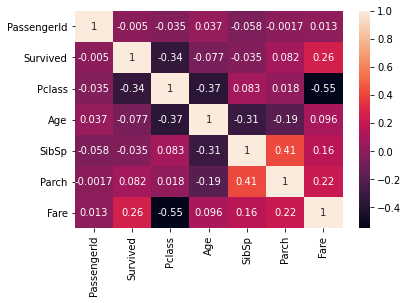

In [110]:
sns.heatmap(train_df.corr(), annot=True)

In [111]:
train_df["Age"].fillna(train_df["Age"].mean(), inplace = True)
train_df['Sex']=train_df['Sex'].replace('male', 0)
train_df['Sex']=train_df['Sex'].replace('female', 1)

In [112]:
train_df.drop(['Name', 'PassengerId', 'Fare', 'Ticket','Embarked', 'Cabin'], axis = 1, inplace = True)

In [113]:
X= train_df.drop('Survived', axis=1)
y= train_df['Survived']

In [114]:
#spliting the dataset to work on train and test


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
len(X)

891

In [115]:
#feature scaling


from sklearn.preprocessing import StandardScaler

scaler= StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [116]:
scaled_X_train= scaler.transform(X_train)
scaled_X_test= scaler.transform(X_test)

In [117]:
y_train=y_train.values

In [118]:
type(y_train)

numpy.ndarray

In [119]:
y_train[y_train == 0] = -1  # Change labels from [0,1] --> [-1,1]

##### Linear kernel

In [120]:
%%time
# Set model parameters and initial values

C = 1000.0
m = len(scaled_X_train)
initial_alphas = np.zeros(m)
initial_b = 0.0

# Set tolerances
tol = 0.01 # error tolerance
eps = 0.01 # alpha tolerance

# Instantiate model
model = SMOModel(scaled_X_train, y_train, C, linear_kernel,
                 initial_alphas, initial_b, np.zeros(m))

# Initialize error cache
initial_error = decision_function(model.alphas, model.y, model.kernel,
                                  model.X, model.X, model.b) - model.y
model.errors = initial_error

Wall time: 19.9 ms


In [121]:
%%time
output = train(model)

Wall time: 5min 41s


In [122]:
out=model.errors+model.y
out

array([ 3.55604813e+02, -7.81478780e+02,  3.72301662e+02, -3.12619287e+02,
        1.68904936e+02,  6.56873266e+02, -5.26493716e+02,  9.81014944e+02,
        2.91722457e+01, -1.78185137e+02, -5.26493716e+02,  1.06813672e+03,
       -4.64669899e+02,  2.78903465e+02, -4.25514190e+02, -5.23653933e+02,
       -5.68494577e+02, -1.24778516e+02, -4.76226706e+02,  1.63661663e+02,
       -6.16658790e+02, -2.76821399e+02, -1.52664184e+02,  3.06385366e+02,
       -4.70448302e+02,  3.31320540e+01, -8.09828733e+02, -5.63612386e+02,
        8.58938698e+02, -4.59353940e+02,  5.37914338e+02,  4.64106242e+02,
       -5.70647576e+02, -6.07740645e+02, -1.37231121e+02, -6.19904098e+02,
       -4.64465135e+02,  1.00531852e+02, -5.26493716e+02,  1.09950352e+03,
       -5.87555425e+02, -7.28206389e+02, -6.40770458e+02,  1.00106966e+03,
       -7.89771011e+02, -6.03220114e+02, -5.28190748e+02,  4.45445680e+02,
       -5.61611431e+02,  9.31751418e+02,  2.69611371e+02, -2.51331421e+02,
        6.11428708e+02,  

In [123]:
out=[1 if i>0 else -1 for i in out]

In [124]:
from sklearn.metrics import classification_report

print(classification_report(y_train, out))

              precision    recall  f1-score   support

          -1       0.81      0.82      0.81       395
           1       0.68      0.67      0.67       228

    accuracy                           0.76       623
   macro avg       0.74      0.74      0.74       623
weighted avg       0.76      0.76      0.76       623

